## Import Libraries

Mix of libraries for data preprocessing, visualization, and modeling.

In [1]:
import random
random.seed(100)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import time

from sklearn import metrics

from tensorflow.keras import layers, models, regularizers

# contains all our functions and classes we wrote for this notebook
import functions_classes as fc

2024-06-13 19:55:18.791312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploration

Here, we will be creating a dataframe with all our image paths (as strings), bloodcell type, and image dimension information. We will take a look at if our data is balanced or not with the bloodcell type counts and the image dimension counts.

In [2]:
# Dataset folder has 8 different folders, which represent 8 different bloodcells we will be classifying
# Open up folder names and remove folder names that are not bloodcell types

# Original kaggle dataset has images stored in each of the 8 folders, so we made a folder that contained all the images
# so that it is easier to convert the images to numpy arrays later on

bloodcells = os.listdir("bloodcells_dataset")
bloodcells = [x for x in bloodcells if x not in ['.DS_Store']]

bloodcells

['basophil',
 'neutrophil',
 'ig',
 'monocyte',
 'eosinophil',
 'erythroblast',
 'lymphocyte',
 'platelet']

A quick look at our image dataframe - we have our image paths, the label encoded bloodcell types, and other important info.

In [3]:
df = fc.image_df(bloodcells)

df.sample(frac = 1).head()

,images,type,type_category,width,height,dimensions
8977,bloodcells_dataset/eosinophil/EO_140071.jpg,1,eosinophil,360,363,360 x 363
10444,bloodcells_dataset/eosinophil/EO_469045.jpg,1,eosinophil,360,363,360 x 363
14259,bloodcells_dataset/lymphocyte/LY_221714.jpg,4,lymphocyte,360,363,360 x 363
2337,bloodcells_dataset/neutrophil/SNE_948962.jpg,6,neutrophil,360,363,360 x 363
8199,bloodcells_dataset/monocyte/MO_133271.jpg,5,monocyte,360,363,360 x 363


Let's take a look at one image from each of our bloodcell types to see what these cells look like.

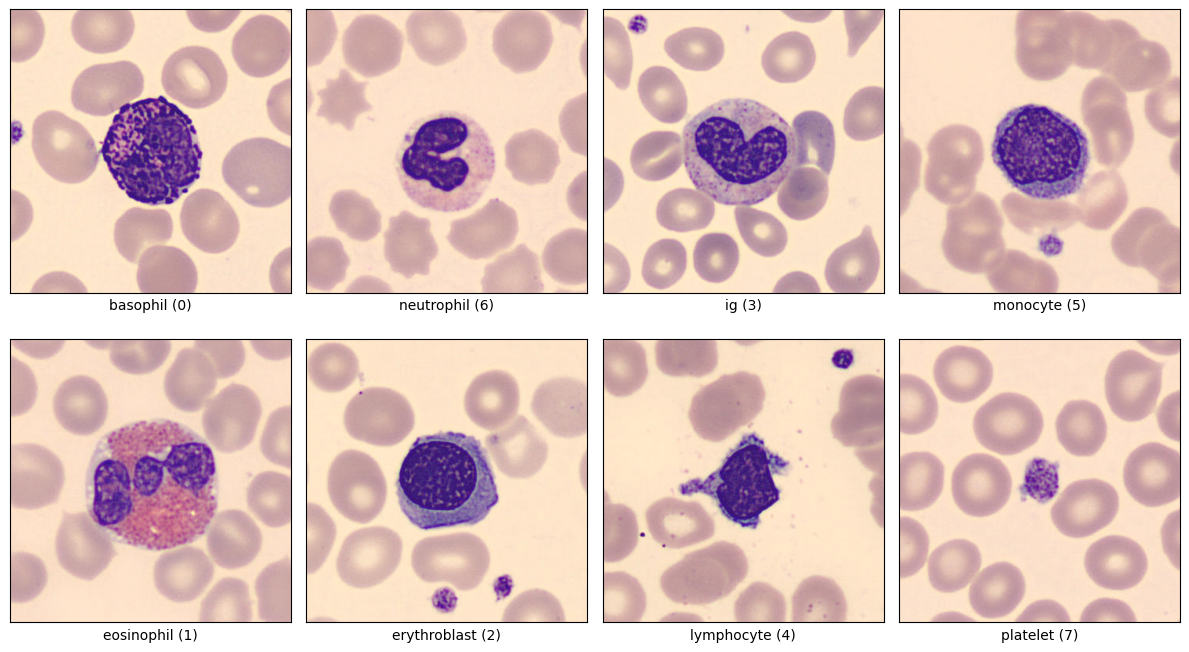

In [4]:
sample_pics = [df[df['type_category'] == x][['images', 'type_category', 'type']].sample(1).values.reshape(3) for x in bloodcells]

fig, ax = plt.subplots(2, 4, figsize = (12, 12))

for i in range(len(sample_pics)):
    
    img = mpimg.imread(sample_pics[i][0])

    if i < 4:
        ax[0, i].imshow(img)
        ax[0, i].set_xlabel(sample_pics[i][1] + f' ({sample_pics[i][2]})')
        ax[0, i].set_xticklabels([])
        ax[0, i].set_yticklabels([])
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
    else:
        ax[1, i - 4].imshow(img)
        ax[1, i - 4].set_xlabel(sample_pics[i][1] + f' ({sample_pics[i][2]})')
        ax[1, i - 4].set_xticklabels([])
        ax[1, i - 4].set_yticklabels([])
        ax[1, i - 4].set_xticks([])
        ax[1, i - 4].set_yticks([])


plt.tight_layout()
plt.subplots_adjust(top = 0.75, bottom = 0.1)

Let's take a look at the distribution of images by dimension (width x height) and by bloodcell type.

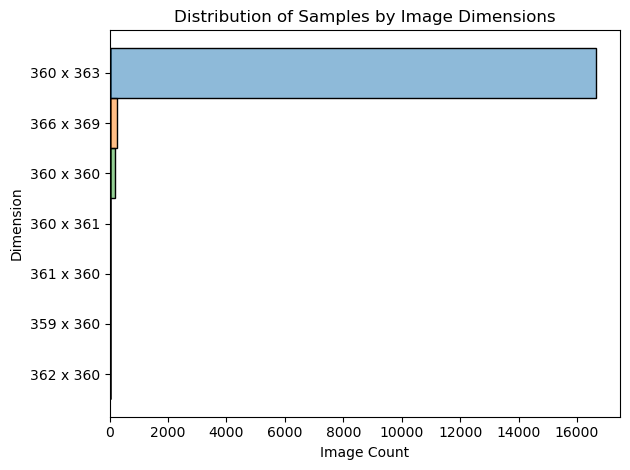

In [5]:
ax = sns.histplot(data = df, y = 'dimensions', hue = 'dimensions')

ax.get_legend().set_visible(False)

plt.xlabel("Image Count")

plt.ylabel("Dimension")

plt.title("Distribution of Samples by Image Dimensions")

plt.tight_layout()

plt.show()

It seems like most images are 360 x 363 pixels, and we will end up resizing the images to 32 pixels later on so the imbalance does not really matter here.

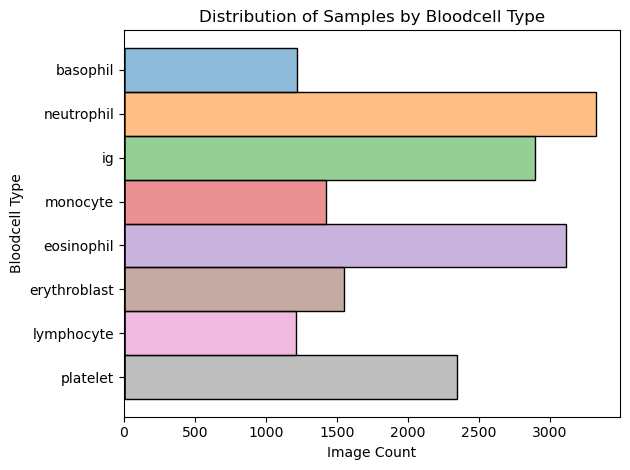

In [6]:
ax = sns.histplot(data = df, y = 'type_category', hue = 'type_category')

ax.get_legend().set_visible(False)

plt.xlabel("Image Count")

plt.ylabel("Bloodcell Type")

plt.title("Distribution of Samples by Bloodcell Type")

plt.tight_layout()

plt.show()

Looking at the number of images we have for each bloodcell type, it is clear we have an imbalanced image count for each type, which we will account for when splitting our data for training and testing.

## Sampling

Now we will create classes to sample our data for train, validation, and test sets and for converting images to arrays that can be used for our models. Because of our imbalanced representation of images for each bloodcell type, we will downsample the image count by type (sample 1000 images for a bloodcell type if the total amount of images for that type is < 2000 images and sample 1500 images if the total amount of images for that type is $\ge$ 2000 images) and in relation to the proportion of each bloodcell type compared to the overall number of images. We will then see if either sampling method results in a better performance when training our models.

In [7]:
# Initialize sampling objects
down_sampling = fc.Sampling(df, 'down')
proportional_sampling = fc.Sampling(df, 'proportional')

# Create train, val, test dataframes for both sampling methods
down_train, down_val, down_test = down_sampling.sample_data()
prop_train, prop_val, prop_test = proportional_sampling.sample_data()

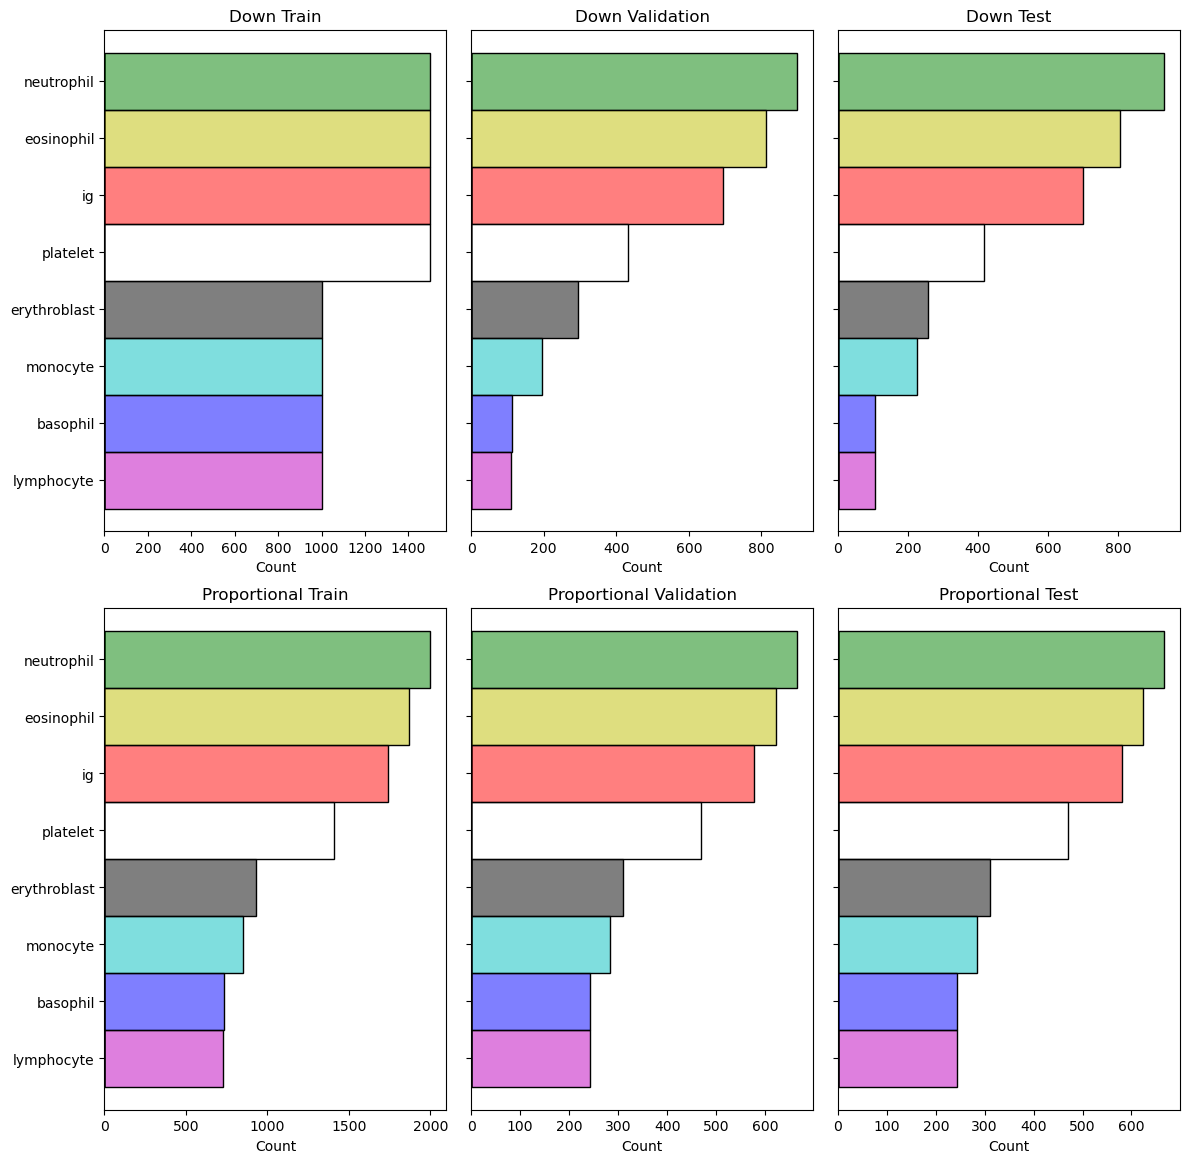

In [8]:
fig, ax = plt.subplots(2, 3, sharey = True, figsize = (12, 12))

colors = ['b', 'g', 'r', 'c', 'y', 'k', 'm', 'w', '#AAFF32']

palette = dict(zip(bloodcells, colors))

sns.histplot(data = down_train, y = 'type_category', hue = 'type_category', ax = ax[0, 0], palette = palette)
ax[0, 0].get_legend().set_visible(False)
ax[0, 0].set(ylabel = '')
ax[0, 0].set_title('Down Train')
sns.histplot(data = down_val, y = 'type_category', hue = 'type_category', ax = ax[0, 1], palette = palette)
ax[0, 1].get_legend().set_visible(False)
ax[0, 1].set_title('Down Validation')
sns.histplot(data = down_test, y = 'type_category', hue = 'type_category', ax = ax[0, 2], palette = palette)
ax[0, 2].get_legend().set_visible(False)
ax[0, 2].set_title('Down Test')

sns.histplot(data = prop_train, y = 'type_category', hue = 'type_category', ax = ax[1, 0], palette = palette)
ax[1, 0].get_legend().set_visible(False)
ax[1, 0].set(ylabel = '')
ax[1, 0].set_title('Proportional Train')
sns.histplot(data = prop_val, y = 'type_category', hue = 'type_category', ax = ax[1, 1], palette = palette)
ax[1, 1].get_legend().set_visible(False)
ax[1, 1].set_title('Proportional Validation')
sns.histplot(data = prop_test, y = 'type_category', hue = 'type_category', ax = ax[1, 2], palette = palette)
ax[1, 2].get_legend().set_visible(False)
ax[1, 2].set_title('Proportional Test')

plt.tight_layout()
plt.subplots_adjust(top = 0.95, bottom = 0.05)

## Images to Arrays
Now that we have our sampling dataframes, we have to convert our images into arrays so that they can be used as input for our models. 

In [9]:
start = time.time()

# initialize image to array objects for train, val, and test dataframes from above
down_train_image_df, down_val_image_df, down_test_image_df = fc.Convert_Images(down_train, data_augment = True), fc.Convert_Images(down_val), fc.Convert_Images(down_test) 
prop_train_image_df, prop_val_image_df, prop_test_image_df = fc.Convert_Images(prop_train, data_augment = True), fc.Convert_Images(prop_val), fc.Convert_Images(prop_test)


# resize images to be 32 x 32 pixels
resize_pixels = 32

# apply image_arrays_and_labels method to objects resulting in arrays and labels
down_train_images, down_train_labels = down_train_image_df.image_arrays_and_labels(resize_pixels)
down_val_images, down_val_labels = down_val_image_df.image_arrays_and_labels(resize_pixels)
down_test_images, down_test_labels = down_test_image_df.image_arrays_and_labels(resize_pixels)
prop_train_images, prop_train_labels = prop_train_image_df.image_arrays_and_labels(resize_pixels)
prop_val_images, prop_val_labels = prop_val_image_df.image_arrays_and_labels(resize_pixels)
prop_test_images, prop_test_labels = prop_test_image_df.image_arrays_and_labels(resize_pixels)

# ~ 30 seconds
print(f'Loading time: {round(time.time() - start, 2)} seconds')

2024-06-13 19:55:26.804713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading time: 28.15 seconds


In [10]:
print(f'down_train_images: {len(down_train_images)} samples ({int(len(down_train_images) / 2)} regular, {int(len(down_train_images) / 2)} augmented)')
print(f'down_val_images: {len(down_val_images)} samples')
print(f'down_test_images: {len(down_test_images)} samples\n')
print(f'prop_train_images: {len(prop_train_images)} samples ({int(len(prop_train_images) / 2)} regular, {int(len(prop_train_images) / 2)} augmented)')
print(f'prop_val_images: {len(prop_val_images)} samples')
print(f'prop_test_images: {len(prop_test_images)} samples')

down_train_images: 20000 samples (10000 regular, 10000 augmented)
down_val_images: 3546 samples
down_test_images: 3546 samples

prop_train_images: 20512 samples (10256 regular, 10256 augmented)
prop_val_images: 3413 samples
prop_test_images: 3423 samples


In [11]:
start = time.time()

# new train, val, test instances of convert image class
edge_down_train, edge_down_val, edge_down_test = fc.Convert_Images(down_train, data_augment = True), fc.Convert_Images(down_val), fc.Convert_Images(down_test)
edge_prop_train, edge_prop_val, edge_prop_test = fc.Convert_Images(prop_train, data_augment = True), fc.Convert_Images(prop_val), fc.Convert_Images(prop_test)

d_edge_train_images, d_edge_train_labels = edge_down_train.image_arrays_and_labels(resize_pixels, edge = True)
d_edge_val_images, d_edge_val_labels = edge_down_val.image_arrays_and_labels(resize_pixels, edge = True)
d_edge_test_images, d_edge_test_labels = edge_down_test.image_arrays_and_labels(resize_pixels, edge = True)
p_edge_train_images, p_edge_train_labels = edge_prop_train.image_arrays_and_labels(resize_pixels, edge = True)
p_edge_val_images, p_edge_val_labels = edge_prop_val.image_arrays_and_labels(resize_pixels, edge = True)
p_edge_test_images, p_edge_test_labels = edge_prop_test.image_arrays_and_labels(resize_pixels, edge = True)

# apply sobel filter vertically and horizontally for edge detection

d_x_sobel_train, d_y_sobel_train, d_norm_train = fc.edge_detection(d_edge_train_images)
d_x_sobel_val, d_y_sobel_val, d_norm_val = fc.edge_detection(d_edge_val_images)
d_x_sobel_test, d_y_sobel_test, d_norm_test = fc.edge_detection(d_edge_test_images)
p_x_sobel_train, p_y_sobel_train, p_norm_train = fc.edge_detection(p_edge_train_images)
p_x_sobel_val, p_y_sobel_val, p_norm_val = fc.edge_detection(p_edge_val_images)
p_x_sobel_test, p_y_sobel_test, p_norm_test = fc.edge_detection(p_edge_test_images)

# ~ 60 seconds
print(f'Loading time: {round(time.time() - start, 2)} seconds')

Loading time: 73.76 seconds


In [12]:
fc.plot_edges(d_edge_val_images, d_x_sobel_val, d_y_sobel_val, d_norm_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Model Building
Now that we have prepped our image data by separating 2 different sampling methods and resizing/normalizing our images, we are ready to start building our models. We will build a train model function that fits different tensorflow models and returns the result of the model on our test data. For other models outside of tensorflow, we will train them manually without a function.

In [13]:
# number of epochs to train models on
epochs_train = 30

# FNN 1

In [14]:
# Simple FNN model
# One for down sampling and proportional sampling

# Simple FNN Model - Down Sampling
fnn_d = models.Sequential(
    
    [
        layers.Dense(64, input_shape = (resize_pixels * resize_pixels * 3, ), activation = 'relu', kernel_initializer = 'he_normal'),
        
        layers.Dense(64, activation = 'relu', kernel_initializer = 'he_normal'),

        layers.Dense(64, activation = 'relu', kernel_initializer = 'he_normal'),
        
        layers.Dense(64, activation = 'relu'), 
        
        layers.Dense(8) # 8 categories                 
    ]
)

# Simple FNN Model - Proportional Sampling
fnn_p = models.clone_model(fnn_d)

fnn_d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                196672    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 209,672
Trainable params: 209,672
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Will need to reshape images into 2d arrays as FNN model cannot accept a 4d input
down_train_images_flat = fc.image_reshape(down_train_images)
down_val_images_flat = fc.image_reshape(down_val_images)
down_test_images_flat = fc.image_reshape(down_test_images)

fnn_d_history, fnn_d_predictions, fnn_d_test_accuracy, fnn_d_confusion_matrix = fc.train_model(fnn_d,
                                                                                               down_train_images_flat,
                                                                                               down_train_labels,
                                                                                               down_val_images_flat,
                                                                                               down_val_labels,
                                                                                               down_test_images_flat,
                                                                                               down_test_labels, 
                                                                                               epochs = epochs_train)

Epoch 1/30
313/313 [==============================] - 2s 4ms/step - loss: 1.5050 - accuracy: 0.3997 - val_loss: 1.2649 - val_accuracy: 0.4831
Epoch 2/30
313/313 [==============================] - 1s 3ms/step - loss: 1.1150 - accuracy: 0.5651 - val_loss: 1.1613 - val_accuracy: 0.5274
Epoch 3/30
313/313 [==============================] - 1s 3ms/step - loss: 0.9468 - accuracy: 0.6403 - val_loss: 0.8230 - val_accuracy: 0.6844
Epoch 4/30
313/313 [==============================] - 1s 3ms/step - loss: 0.8787 - accuracy: 0.6648 - val_loss: 0.9101 - val_accuracy: 0.6500
Epoch 5/30
313/313 [==============================] - 1s 3ms/step - loss: 0.8565 - accuracy: 0.6740 - val_loss: 0.7952 - val_accuracy: 0.6819
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 0.8385 - accuracy: 0.6791 - val_loss: 0.9807 - val_accuracy: 0.6289
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 0.7964 - accuracy: 0.6966 - val_loss: 0.7078 - val_accuracy: 0.7318
Epoch 

In [ ]:
fnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = fnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(fnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, fnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, fnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Will need to reshape images into 2d arrays as FNN model cannot accept a 4d input
prop_train_images_flat = fc.image_reshape(prop_train_images)
prop_val_images_flat = fc.image_reshape(prop_val_images)
prop_test_images_flat = fc.image_reshape(prop_test_images)

fnn_p_history, fnn_p_predictions, fnn_p_test_accuracy, fnn_p_confusion_matrix = fc.train_model(fnn_p,
                                                                                               prop_train_images_flat,
                                                                                               prop_train_labels,
                                                                                               prop_val_images_flat,
                                                                                               prop_val_labels,
                                                                                               prop_test_images_flat,
                                                                                               prop_test_labels, 
                                                                                               epochs = epochs_train)

In [ ]:
fnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = fnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(fnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, fnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, fnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

# CNN 1

In [ ]:
# Simple CNN model

# Down Sampling
cnn1_d_norm = models.Sequential(
    
    [
        layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3)),
        
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation = 'relu'),

        # flatten into 1d array
        layers.Flatten(),

        # Neural network
        layers.Dense(64, activation = 'relu'),

        layers.Dropout(rate = 0.2),
        
        # 8 different categories
        layers.Dense(8) 
    ]
    
)

# Proportional Sampling
cnn1_p_norm = models.clone_model(cnn1_d_norm)

# Down Sampling (Edge)
cnn1_d_edge = models.clone_model(cnn1_d_norm)

# Proportional Sampling (Edge)
cnn1_p_edge = models.clone_model(cnn1_d_norm)

cnn1_d_norm.summary()

In [ ]:
# Normal - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn1_d_norm,
                                                                                               down_train_images,
                                                                                               down_train_labels,
                                                                                               down_val_images,
                                                                                               down_val_labels,
                                                                                               down_test_images,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Normal - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn1_p_norm,
                                                                                               prop_train_images,
                                                                                               prop_train_labels,
                                                                                               prop_val_images,
                                                                                               prop_val_labels,
                                                                                               prop_test_images,
                                                                                               prop_test_labels, 
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn1_d_edge,
                                                                                               d_norm_train,
                                                                                               down_train_labels,
                                                                                               d_norm_val,
                                                                                               down_val_labels,
                                                                                               d_norm_test,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn1_p_edge,
                                                                                               p_norm_train,
                                                                                               prop_train_labels,
                                                                                               p_norm_val,
                                                                                               prop_val_labels,
                                                                                               p_norm_test,
                                                                                               prop_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

# CNN 2

In [ ]:
# CNN 2
# Added dropout layers

# Down Sampling
cnn2_d_norm = models.Sequential(
    
    [
        layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3)),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(64, (3, 3), activation = 'relu'),
        
        # flatten into 1d array
        layers.Flatten(),

        # Neural network
        layers.Dense(64, activation = 'relu'),

        layers.Dropout(rate = 0.2),

        # 8 different categories
        layers.Dense(8) 
    ]   
)

# Proportional Sampling
cnn2_p_norm = models.clone_model(cnn2_d_norm)

# Down Sampling (Edge)
cnn2_d_edge = models.clone_model(cnn2_d_norm)

# Proportional Sampling (Edge)
cnn2_p_edge = models.clone_model(cnn2_d_norm)

cnn2_d_norm.summary()

In [ ]:
# Normal - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn2_d_norm,
                                                                                               down_train_images,
                                                                                               down_train_labels,
                                                                                               down_val_images,
                                                                                               down_val_labels,
                                                                                               down_test_images,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Normal - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn2_p_norm,
                                                                                               prop_train_images,
                                                                                               prop_train_labels,
                                                                                               prop_val_images,
                                                                                               prop_val_labels,
                                                                                               prop_test_images,
                                                                                               prop_test_labels, 
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn2_d_edge,
                                                                                               d_norm_train,
                                                                                               down_train_labels,
                                                                                               d_norm_val,
                                                                                               down_val_labels,
                                                                                               d_norm_test,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn2_p_edge,
                                                                                               p_norm_train,
                                                                                               prop_train_labels,
                                                                                               p_norm_val,
                                                                                               prop_val_labels,
                                                                                               p_norm_test,
                                                                                               prop_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

# CNN 3

In [ ]:
# CNN 3
# Added more layers and regularization

l1 = 0.02
l2 = 0.02

# Down Sampling
cnn3_d_norm = models.Sequential(
    
    [
        
        layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3), kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        layers.Conv2D(32, (3, 3), activation = "relu", kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        # flatten into 1d array
        layers.Flatten(),

        # Neural network
        layers.Dense(64, activation = 'relu'),

        layers.Dropout(rate = 0.2),

        # 8 different categories
        layers.Dense(8) 
    ]   
)


# Proportional Sampling
cnn3_p_norm = models.clone_model(cnn3_d_norm)

# Down Sampling (Edge)
cnn3_d_edge = models.clone_model(cnn3_d_norm)

# Proportional Sampling (Edge)
cnn3_p_edge = models.clone_model(cnn3_d_norm)

cnn3_d_norm.summary()

In [ ]:
# Normal - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn3_d_norm,
                                                                                               down_train_images,
                                                                                               down_train_labels,
                                                                                               down_val_images,
                                                                                               down_val_labels,
                                                                                               down_test_images,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Normal - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn3_p_norm,
                                                                                               prop_train_images,
                                                                                               prop_train_labels,
                                                                                               prop_val_images,
                                                                                               prop_val_labels,
                                                                                               prop_test_images,
                                                                                               prop_test_labels, 
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn3_d_edge,
                                                                                               d_norm_train,
                                                                                               down_train_labels,
                                                                                               d_norm_val,
                                                                                               down_val_labels,
                                                                                               d_norm_test,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn3_p_edge,
                                                                                               p_norm_train,
                                                                                               prop_train_labels,
                                                                                               p_norm_val,
                                                                                               prop_val_labels,
                                                                                               p_norm_test,
                                                                                               prop_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

# CNN 4

In [ ]:
# CNN 4
# Combination of previous 3 CNNs

l1 = 0.02
l2 = 0.02

# Down Sampling
cnn4_d_norm = models.Sequential(
    
    [
        layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3)),

        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        # layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        # layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(64, (3, 3), activation = 'relu'),
        
        # layers.Conv2D(64, (3, 3), activation = "relu", kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        # flatten into 1d array
        layers.Flatten(),

        # Neural network
        layers.Dense(64, activation = 'relu'),

        layers.Dropout(rate = 0.2),

        # 8 different categories
        layers.Dense(8) 
    ]   
)

# Proportional Sampling
cnn4_p_norm = models.clone_model(cnn4_d_norm)

# Down Sampling (Edge)
cnn4_d_edge = models.clone_model(cnn4_d_norm)

# Proportional Sampling (Edge)
cnn4_p_edge = models.clone_model(cnn4_d_norm)

cnn4_d_norm.summary()

In [ ]:
# Normal - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn4_d_norm,
                                                                                               down_train_images,
                                                                                               down_train_labels,
                                                                                               down_val_images,
                                                                                               down_val_labels,
                                                                                               down_test_images,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Normal - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn4_p_norm,
                                                                                               prop_train_images,
                                                                                               prop_train_labels,
                                                                                               prop_val_images,
                                                                                               prop_val_labels,
                                                                                               prop_test_images,
                                                                                               prop_test_labels, 
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Down
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = fc.train_model(cnn4_d_edge,
                                                                                               d_norm_train,
                                                                                               down_train_labels,
                                                                                               d_norm_val,
                                                                                               down_val_labels,
                                                                                               d_norm_test,
                                                                                               down_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Edge - Proportional
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = fc.train_model(cnn4_p_edge,
                                                                                               p_norm_train,
                                                                                               prop_train_labels,
                                                                                               p_norm_val,
                                                                                               prop_val_labels,
                                                                                               p_norm_test,
                                                                                               prop_test_labels,
                                                                                               epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()